In [26]:
import numpy as np
import matplotlib.pyplot as plt

from datastructures import *
from training import *
from models import *
from residuals import *
from analysis import *

In [27]:
# ----- config you can tweak -----
num_layers_grid = [2, 3, 4, 5]   # scan over these depths
hidden_dim      = 128
dropout         = 0.1
residual_conn   = True
norm_kind       = 'layer'                   # 'layer' | 'batch' | None
min_pos         = 10           # organoids with <min_pos positives for a marker are skipped in stats
eps_den         = 1e-8         # to avoid division by ~0 when marker mean ≈ 0

# training params (kept modest to make the scan manageable)
cfg = TrainConfig(
    lr=1e-3,
    batch_size=8,
    max_epochs=100,
    patience=30,
    huber_delta=0.0,        # MSE for clean comparison
)

# markers to analyze (must match entries in marker_names)
interest_markers = ["LGR5", "AldoB", "Lysozyme", "Serotonin"]

In [28]:
# 1) Load all organoids
data_dir = "training_data"
graphs = load_dir_to_graphs(data_dir)
print(f"Loaded {len(graphs)} organoids.")
marker_names = load_marker_names_from_dir(data_dir)

# 2) (Optional) global outlier filtering BEFORE split (applies to all)
low_pct, high_pct = 0.0, 100.0   # example: keep middle 0–95th percentile
graphs, thr = filter_outliers(graphs, low_pct=low_pct, high_pct=high_pct, stat="median")
print(f"After global filter: {len(graphs)} organoids | thresholds: {thr}")

# 3) Split by organoid
g_train, g_val = split_graphs(graphs, val_frac=0.2, seed=None)
print(f"Split -> train: {len(g_train)} | val: {len(g_val)}")


for g in g_train: add_two_hop_edges_inplace(g, include_self_loops=False, keep_one_hop=True)
for g in g_val:   add_two_hop_edges_inplace(g, include_self_loops=False, keep_one_hop=True)


Loaded 999 graphs; skipped 0.
Loaded 999 organoids.
After global filter: 999 organoids | thresholds: {'low': -0.41922950744628906, 'high': 0.5147268772125244}
Split -> train: 799 | val: 200


In [29]:
# ----- helpers -----
def marker_indices(marker_names, wanted):
    m2i = {n:i for i,n in enumerate(marker_names)}
    idx = [m2i[w] for w in wanted if w in m2i]
    missing = [w for w in wanted if w not in m2i]
    if missing:
        print("⚠ Missing markers:", missing)
    return idx

def per_organoid_arrays(graphs, yhat_fn):
    """
    Returns lists (per organoid): X_i, y_true_i, y_pred_i (all numpy arrays).
    yhat_fn(graph) should return (y_true_abs, y_pred_abs).
    """
    Xs, Ys, YHs = [], [], []
    for g in graphs:
        Xs.append(g.x.cpu().numpy())
        y_true, y_pred = yhat_fn(g)
        Ys.append(y_true); YHs.append(y_pred)
    return Xs, Ys, YHs

def make_yhat_fn_raw(model, device):
    @torch.no_grad()
    def fn(g):
        # IMPORTANT: clone before .to(device) to avoid mutating the original graph
        gg = g.clone()
        gg = gg.to(device, non_blocking=True)
        model.eval().to(device)
        y_pred, _ = model(gg.x, gg.edge_index)
        # prefer absolute y if present
        y_true = gg.y if not hasattr(g, "y_orig") else g.y_orig
        return y_true.cpu().numpy(), y_pred.cpu().numpy()
    return fn

def make_yhat_fn_residual(model, mu_dict, device):
    from residuals import per_node_baseline_from_markers
    mu_pos  = torch.as_tensor(mu_dict["mu_pos"], dtype=torch.float32, device=device)
    mu_none = float(mu_dict["mu_none"])

    @torch.no_grad()
    def fn(g):
        # Clone to keep original on CPU
        gg = g.clone().to(device, non_blocking=True)
        model.eval().to(device)
        r_hat, _ = model(gg.x, gg.edge_index)
        b = per_node_baseline_from_markers(gg.x, mu_pos, mu_none)
        y_pred = b + r_hat
        y_true = gg.y if not hasattr(g, "y_orig") else g.y_orig
        return y_true.cpu().numpy(), y_pred.cpu().numpy()
    return fn

def split_marker_mean(y_list, X_list):
    """
    Split-wide mean curvature per marker (positives only), computed across all organoids in the split.
    Returns (M,) array.
    """
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    M = X_all.shape[1]
    mu = np.zeros(M, dtype=float)
    for m in range(M):
        mask = X_all[:, m] > 0.5
        mu[m] = float(np.mean(y_all[mask])) if mask.any() else 0.0
    return mu

def per_marker_rel_mse_across_organoids(X_list, y_list, yhat_list, mu_marker, min_pos=10, eps=1e-8):
    """
    For each marker m, compute per-organoid MSE(y_true,y_pred) over positives of marker m, then
    divide by (mu_marker[m]^2 + eps). Return per-marker mean and **SEM** (not STD) across organoids.
    """
    M = X_list[0].shape[1]
    rel_mse_means = np.full(M, np.nan)
    rel_mse_stds  = np.full(M, np.nan)   # holds SEM for compatibility

    for m in range(M):
        denom = (mu_marker[m]**2) + eps
        rels = []
        for X, y, yh in zip(X_list, y_list, yhat_list):
            mask = X[:, m] > 0.5
            if np.count_nonzero(mask) >= min_pos:
                mse = np.mean((y[mask] - yh[mask])**2)
                rels.append(mse / denom)
        if len(rels) > 0:
            rels = np.asarray(rels, dtype=float)
            rel_mse_means[m] = float(np.mean(rels))
            # SEM = std / sqrt(n)
            rel_mse_stds[m]  = float(np.std(rels, ddof=1) / np.sqrt(len(rels))) if len(rels) > 1 else 0.0
    return rel_mse_means, rel_mse_stds


def per_marker_rel_mse_baseline_across_organoids(X_list, y_list, mu_marker, min_pos=10, eps=1e-8):
    """
    Baseline predictor: y_hat = μ_marker[m] for positives of marker m.
    Returns per-marker mean and **SEM** (not STD) across organoids, normalized by (μ_marker[m]^2 + eps).
    """
    M = X_list[0].shape[1]
    rel_mse_means = np.full(M, np.nan)
    rel_mse_stds  = np.full(M, np.nan)   # holds SEM for compatibility

    for m in range(M):
        denom = (mu_marker[m]**2) + eps
        rels = []
        for X, y in zip(X_list, y_list):
            mask = X[:, m] > 0.5
            if np.count_nonzero(mask) >= min_pos:
                mu_m = mu_marker[m]
                mse  = np.mean((y[mask] - mu_m)**2)
                rels.append(mse / denom)
        if len(rels) > 0:
            rels = np.asarray(rels, dtype=float)
            rel_mse_means[m] = float(np.mean(rels))
            # SEM = std / sqrt(n)
            rel_mse_stds[m]  = float(np.std(rels, ddof=1) / np.sqrt(len(rels))) if len(rels) > 1 else 0.0
    return rel_mse_means, rel_mse_stds


In [30]:
# ----- indices for the markers of interest -----
m_idx = marker_indices(marker_names, interest_markers)
if not m_idx:
    raise RuntimeError("None of the requested markers found in marker_names.")

# ----- storage: for each marker index, store curves over num_layers (train & val) with error bars -----
curves = {
    "raw_train":  {mi: {"mean": [], "std": []} for mi in m_idx},
    "raw_val":    {mi: {"mean": [], "std": []} for mi in m_idx},
    "res_train":  {mi: {"mean": [], "std": []} for mi in m_idx},
    "res_val":    {mi: {"mean": [], "std": []} for mi in m_idx},
    "base_train": {mi: {"mean": [], "std": []} for mi in m_idx},
    "base_val":   {mi: {"mean": [], "std": []} for mi in m_idx},
}

device = cfg.device

# Precompute residual baselines from TRAIN (used for residual training & eval)
mu_dict = compute_marker_baseline_means(g_train)

for L in num_layers_grid:
    print(f"\n=== num_layers = {L} ===")

    n_markers = int(g_train[0].x.size(1))

    # ----- RAW model -----
    raw_model = PureSAGECurvature(
        n_markers=n_markers,
        hidden_dim=hidden_dim,
        num_layers=L,
        dropout=dropout,
        residual=residual_conn,
        norm=norm_kind
    )
    raw_model, _, _ = train(raw_model, g_train, g_val, cfg)
    yhat_raw_train = make_yhat_fn_raw(raw_model, device)
    yhat_raw_val   = make_yhat_fn_raw(raw_model, device)

    X_tr, y_tr, yh_tr = per_organoid_arrays(g_train, yhat_raw_train)
    X_vl, y_vl, yh_vl = per_organoid_arrays(g_val,   yhat_raw_val)

    # Concatenate TRAIN+VAL once for the denominator mean
    mu_full_raw = split_marker_mean(y_tr + y_vl, X_tr + X_vl)

    mean_tr, std_tr = per_marker_rel_mse_across_organoids(
        X_tr, y_tr, yh_tr, mu_full_raw, min_pos=min_pos, eps=eps_den
    )
    mean_vl, std_vl = per_marker_rel_mse_across_organoids(
        X_vl, y_vl, yh_vl, mu_full_raw, min_pos=min_pos, eps=eps_den
    )

    # Baseline (use the same global mean for both TRAIN and VAL)
    base_mean_tr, base_std_tr = per_marker_rel_mse_baseline_across_organoids(
        X_tr, y_tr, mu_full_raw, min_pos=min_pos, eps=eps_den
    )
    base_mean_vl, base_std_vl = per_marker_rel_mse_baseline_across_organoids(
        X_vl, y_vl, mu_full_raw, min_pos=min_pos, eps=eps_den
    )


    for mi in m_idx:
        curves["raw_train"][mi]["mean"].append(mean_tr[mi])
        curves["raw_train"][mi]["std"].append(std_tr[mi])
        curves["raw_val"][mi]["mean"].append(mean_vl[mi])
        curves["raw_val"][mi]["std"].append(std_vl[mi])

    for mi in m_idx:
        # append same numbers at each depth so the baseline shows as a flat curve
        curves["base_train"][mi]["mean"].append(base_mean_tr[mi])
        curves["base_train"][mi]["std"].append(base_std_tr[mi])
        curves["base_val"][mi]["mean"].append(base_mean_vl[mi])
        curves["base_val"][mi]["std"].append(base_std_vl[mi])

    # ----- RESIDUAL model -----
    # residualize datasets (deep copies so originals remain intact)
    g_train_r = residualize_graphs(g_train, mu_dict)
    g_val_r   = residualize_graphs(g_val,   mu_dict)

    res_model = PureSAGECurvature(
        n_markers=n_markers,
        hidden_dim=hidden_dim,
        num_layers=L,
        dropout=dropout,
        residual=residual_conn,
        norm=norm_kind
    )
    res_model, _, _ = train(res_model, g_train_r, g_val_r, cfg)
    yhat_res_train = make_yhat_fn_residual(res_model, mu_dict, device)
    yhat_res_val   = make_yhat_fn_residual(res_model, mu_dict, device)

    X_tr_r, y_tr_r, yh_tr_r = per_organoid_arrays(g_train_r, yhat_res_train)
    X_vl_r, y_vl_r, yh_vl_r = per_organoid_arrays(g_val_r,   yhat_res_val)

    # Global marker mean across TRAIN+VAL in absolute space (for denominator)
    mu_full_res = split_marker_mean(y_tr_r + y_vl_r, X_tr_r + X_vl_r)

    mean_tr_r, std_tr_r = per_marker_rel_mse_across_organoids(
        X_tr_r, y_tr_r, yh_tr_r, mu_full_res, min_pos=min_pos, eps=eps_den
    )
    mean_vl_r, std_vl_r = per_marker_rel_mse_across_organoids(
        X_vl_r, y_vl_r, yh_vl_r, mu_full_res, min_pos=min_pos, eps=eps_den
    )

    for mi in m_idx:
        curves["res_train"][mi]["mean"].append(mean_tr_r[mi])
        curves["res_train"][mi]["std"].append(std_tr_r[mi])
        curves["res_val"][mi]["mean"].append(mean_vl_r[mi])
        curves["res_val"][mi]["std"].append(std_vl_r[mi])


=== num_layers = 2 ===
epoch 001 | train loss 0.0542 mae 0.2021 | val loss 0.0516 mae 0.1237
epoch 002 | train loss 0.0390 mae 0.1467 | val loss 0.0508 mae 0.1175
epoch 003 | train loss 0.0363 mae 0.1312 | val loss 0.0512 mae 0.1175
epoch 004 | train loss 0.0354 mae 0.1260 | val loss 0.0531 mae 0.1355
epoch 005 | train loss 0.0344 mae 0.1192 | val loss 0.0512 mae 0.1192
epoch 006 | train loss 0.0341 mae 0.1174 | val loss 0.0510 mae 0.1178
epoch 007 | train loss 0.0342 mae 0.1182 | val loss 0.0520 mae 0.1279
epoch 008 | train loss 0.0340 mae 0.1169 | val loss 0.0507 mae 0.1158
epoch 009 | train loss 0.0338 mae 0.1160 | val loss 0.0510 mae 0.1166
epoch 010 | train loss 0.0342 mae 0.1172 | val loss 0.0508 mae 0.1173
epoch 011 | train loss 0.0335 mae 0.1126 | val loss 0.0509 mae 0.1172
epoch 012 | train loss 0.0338 mae 0.1145 | val loss 0.0512 mae 0.1200
epoch 013 | train loss 0.0337 mae 0.1141 | val loss 0.0507 mae 0.1159
epoch 014 | train loss 0.0335 mae 0.1125 | val loss 0.0508 mae 0.1

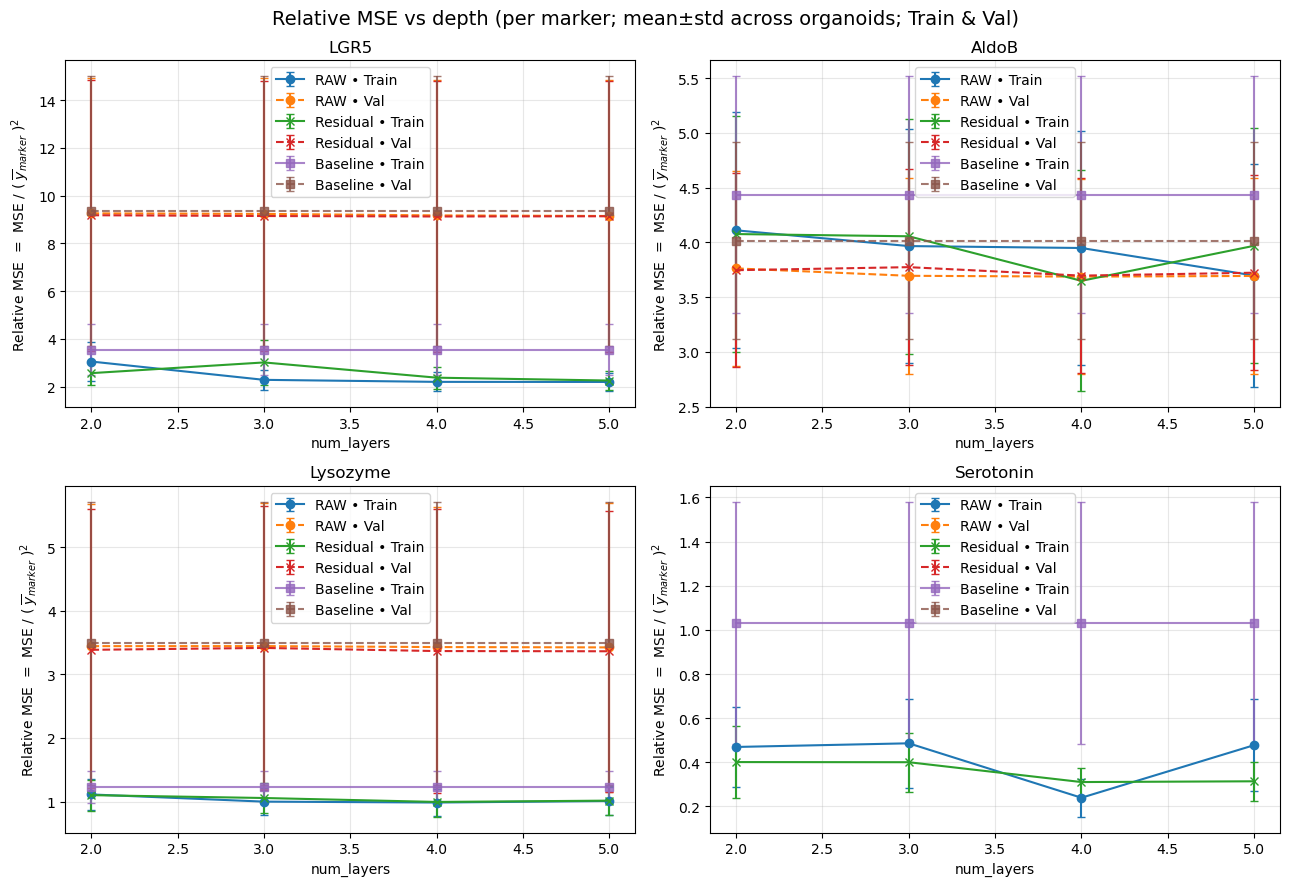

In [31]:
# ----- Plot: for each marker, TRAIN & VAL curves with error bars -----
cols = 2
rows = int(np.ceil(len(m_idx) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False)
axes = axes.ravel()

for ax_i, mi in enumerate(m_idx):
    ax = axes[ax_i]
    # RAW
    ax.errorbar(num_layers_grid, curves["raw_train"][mi]["mean"], yerr=curves["raw_train"][mi]["std"],
                fmt='o-', capsize=3, label="RAW • Train")
    ax.errorbar(num_layers_grid, curves["raw_val"][mi]["mean"],   yerr=curves["raw_val"][mi]["std"],
                fmt='o--', capsize=3, label="RAW • Val")
    # RES
    ax.errorbar(num_layers_grid, curves["res_train"][mi]["mean"], yerr=curves["res_train"][mi]["std"],
                fmt='x-', capsize=3, label="Residual • Train")
    ax.errorbar(num_layers_grid, curves["res_val"][mi]["mean"],   yerr=curves["res_val"][mi]["std"],
                fmt='x--', capsize=3, label="Residual • Val")
    # BASE
    ax.errorbar(num_layers_grid, curves["base_train"][mi]["mean"],
                yerr=curves["base_train"][mi]["std"],
                fmt='s-', capsize=3, label="Baseline • Train", alpha=0.8)
    ax.errorbar(num_layers_grid, curves["base_val"][mi]["mean"],
                yerr=curves["base_val"][mi]["std"],
                fmt='s--', capsize=3, label="Baseline • Val", alpha=0.8)

    ax.set_title(marker_names[mi])
    ax.set_xlabel("num_layers")
    ax.set_ylabel(r"Relative MSE  =  MSE / ( $\overline{y}_{marker}$ )$^2$")
    ax.grid(True, alpha=0.3)
    ax.legend()

# hide unused axes
for k in range(len(m_idx), len(axes)):
    axes[k].axis('off')

fig.suptitle("Relative MSE vs depth (per marker; mean±std across organoids; Train & Val)", fontsize=14)
plt.tight_layout(); plt.show()

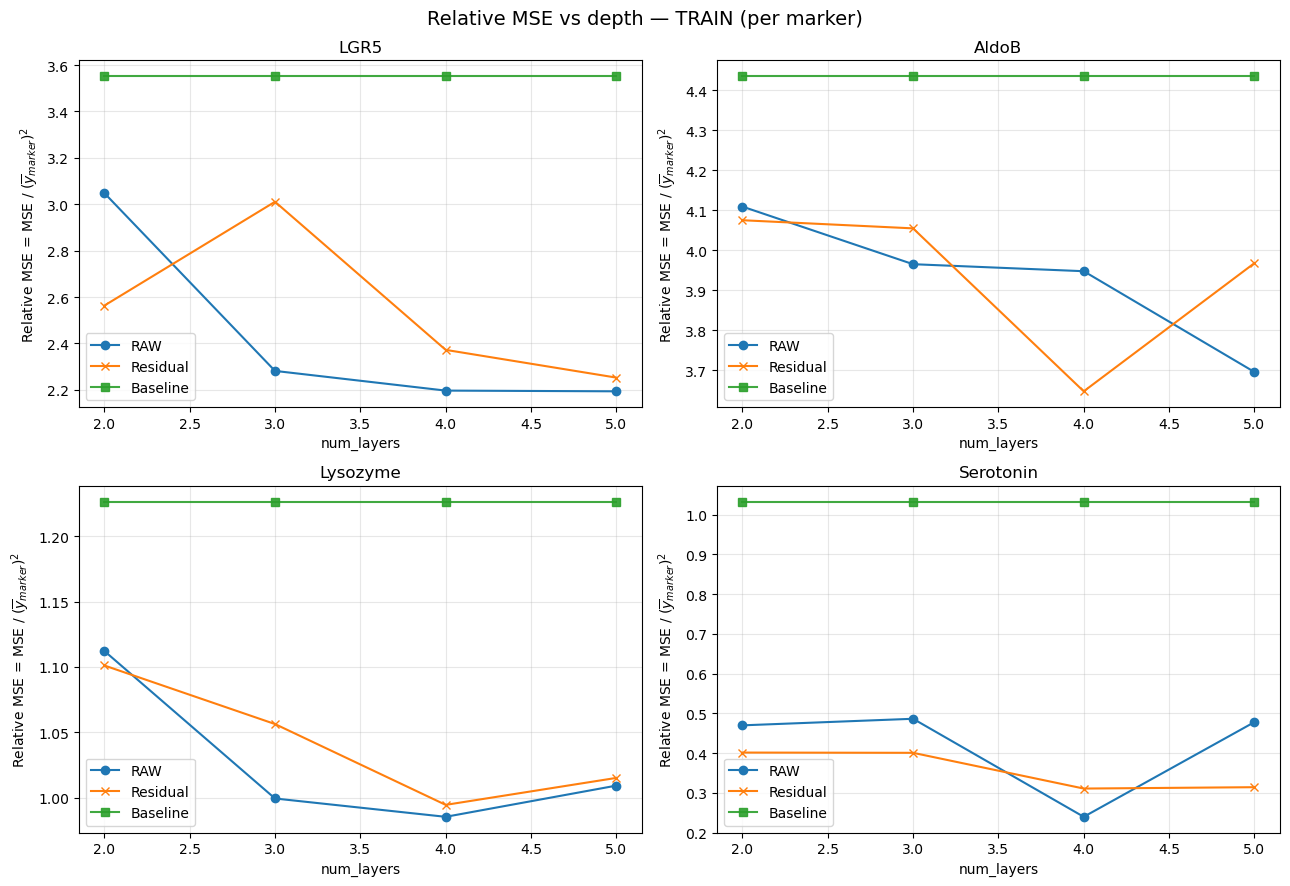

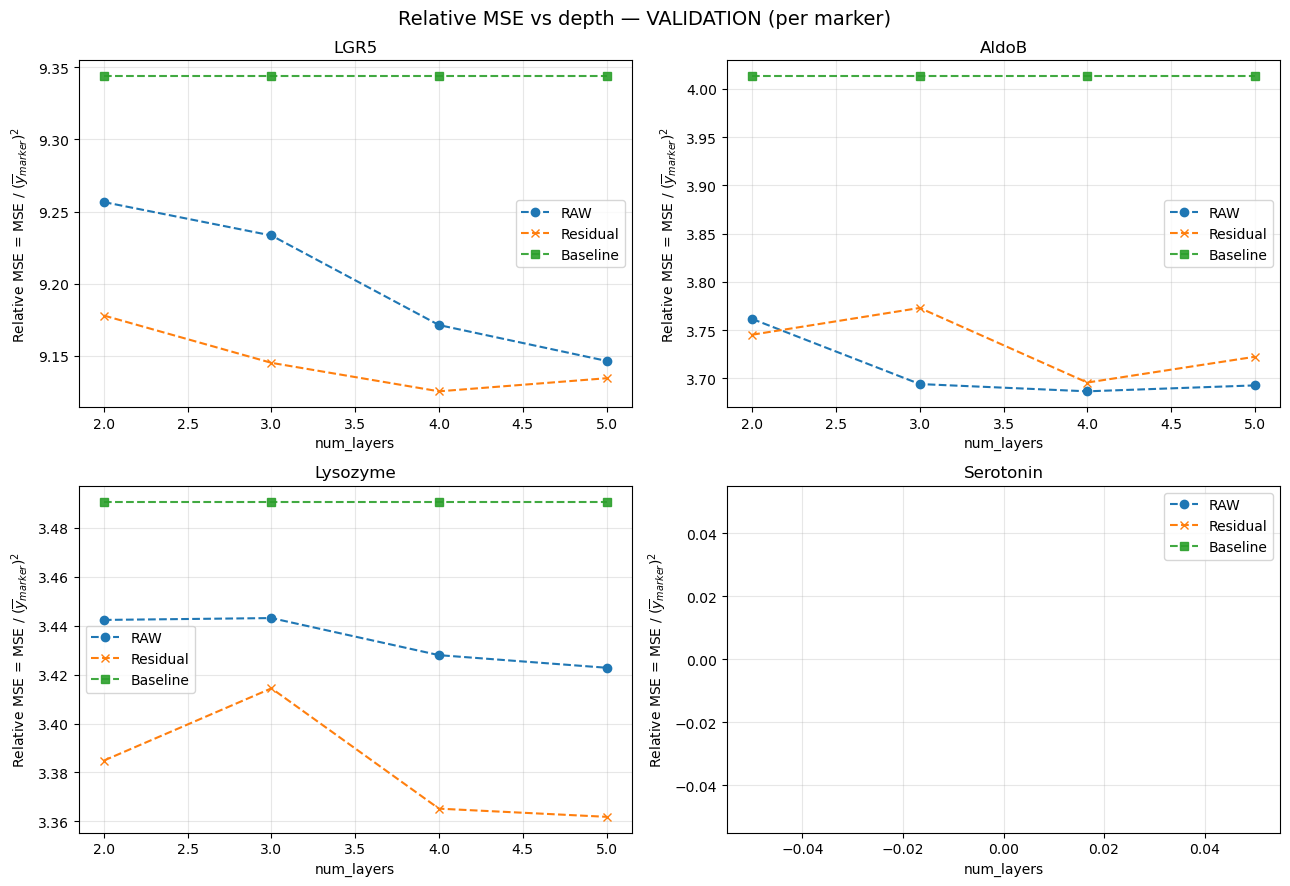

In [32]:
# ===== Figure 1: TRAIN =====
cols = 2
rows = int(np.ceil(len(m_idx) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False)
axes = axes.ravel()

for ax_i, mi in enumerate(m_idx):
    ax = axes[ax_i]
    ax.plot(num_layers_grid, curves["raw_train"][mi]["mean"], 'o-',  label="RAW")
    ax.plot(num_layers_grid, curves["res_train"][mi]["mean"], 'x-',  label="Residual")
    ax.plot(num_layers_grid, curves["base_train"][mi]["mean"], 's-', label="Baseline", alpha=0.9)
    ax.set_title(marker_names[mi])
    ax.set_xlabel("num_layers"); ax.set_ylabel(r"Relative MSE = MSE / ($\overline{y}_{marker}$)$^2$")
    ax.grid(True, alpha=0.3); ax.legend()

for k in range(len(m_idx), len(axes)): axes[k].axis('off')
fig.suptitle("Relative MSE vs depth — TRAIN (per marker)", fontsize=14)
plt.tight_layout(); plt.show()


# ===== Figure 2: VALIDATION =====
cols = 2
rows = int(np.ceil(len(m_idx) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False)
axes = axes.ravel()

for ax_i, mi in enumerate(m_idx):
    ax = axes[ax_i]
    ax.plot(num_layers_grid, curves["raw_val"][mi]["mean"], 'o--',  label="RAW")
    ax.plot(num_layers_grid, curves["res_val"][mi]["mean"], 'x--',  label="Residual")
    ax.plot(num_layers_grid, curves["base_val"][mi]["mean"], 's--', label="Baseline", alpha=0.9)
    ax.set_title(marker_names[mi])
    ax.set_xlabel("num_layers"); ax.set_ylabel(r"Relative MSE = MSE / ($\overline{y}_{marker}$)$^2$")
    ax.grid(True, alpha=0.3); ax.legend()

for k in range(len(m_idx), len(axes)): axes[k].axis('off')
fig.suptitle("Relative MSE vs depth — VALIDATION (per marker)", fontsize=14)
plt.tight_layout(); plt.show()
